In [3]:

#by Henry Schumacher
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
import os
import sys
import json
import uuid
import xraydb
import plotly
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
import numpy as np
import pandas as pd
import pyxray as xy
import seaborn as sb
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "text.usetex": True,
    "font.size": 8,
    "pgf.rcfonts": False
})
# rc('font',**{'family':'serif','serif':['Times']})
# rc('text', usetex=True)
# plt.rcParams.update({'font.size': 8})

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": "\n".join([
          r"\usepackage{mathtools}",
     ]),
})
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
def dual_print(*args, **kwargs):
    print(*args)
    with open('bins_matching_log.txt', 'a') as out:
        print(*args, **kwargs, file=out)
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
from json_to_np import *
from colors import load_colors
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#


mac = hex(uuid.getnode())
print(f"MAC address: {mac}")

mac_dict = {'0xb6ab0b4445f9': ['C://Users//schum//Documents//Filing Cabinet//1_RootFilesGeant4', 'C://Users//schum//Documents//Filing Cabinet//2_jsonFiles'], # Office
            '0x145afc4fe836': ['C://Users//schum//Documents//root_files_temp_storage', 'C://Users//schum//Documents//json_files_temp_storage'], # Laptop
            '0x1a7dda7115'  : ['B://IBA//root', 'B://IBA//json']} # Home PC
# Each mac adresse leads to a pair of paths, the first being the folder, 
# where the root files are, the second, where the json files are supposed to be stored
# root_path = mac_dict[mac][0]
json_path = mac_dict[mac][1]

color_schemes = load_colors()
# print(color_schemes)

MAC address: 0xb6ab0b4445f9


In [73]:
def xray_line_searcher(energy_low, energy_high):
    '''
    energy_low/high: in eV
    '''
    matching = []

    for Z in range(1, 101):  # Elements from Hydrogen (Z=1) to Fermium (Z=100)
        element = xraydb.atomic_symbol(Z)

        # Get all known X-ray lines for the element
        try:
            lines = xraydb.xray_lines(element)
        except Exception:
            continue  # Skip elements that don't have data
        
        # print(lines)
        for line_id, line in lines.items():
            line_energy = line.energy  # Energy in keV
            if (energy_low <= line_energy and line_energy <= energy_high):
                matching.append({
                    'element': element,
                    'Z': Z,
                    'transition': line_id,
                    'energy_keV': line_energy,
                    'intensity': line.intensity
                })

    return matching

In [109]:
def peak_text_prompter(peaks, counts, bin_edges, delta_bin):
    '''
    Energies from this function are in keV! \n
    '''
    energy_bins = {}
    output = open('bins_matching_log.txt', 'w')
    
    dual_print('--'.ljust(80,'-'))
    dual_print('Bin'.ljust(8) + '| ' + 'E_range (eV)'.ljust(18) + '| ' + 'El.'.ljust(4)  + '| ' + 'Line'.ljust(6) + '| ' + 'Energy (eV)'.ljust(12) + '| ' + 'Int.'.ljust(6))
    
    for p in peaks:
        energy_bins[p] = [bin_edges[p], bin_edges[p] + delta_bin/2, bin_edges[p+1]]
        
        E_low = round(energy_bins[p][0]*10**6,4)
        E_high = round(energy_bins[p][2]*10**6,4)
        matching = xray_line_searcher(E_low, E_high)
        # print(matching[0])
        # print(energy_bins[p])
        dual_print(f'Bin {p}'.ljust(8) + '| ' + f'{round(energy_bins[p][0]*10**6,1)} - {round(energy_bins[p][2]*10**6,1)}'.ljust(18) + '| ' + '-'.ljust(33,'-'))
        
        for line in matching:
            dual_print(''.ljust(28) + '| ' + str(line['element']).ljust(4) + '| ' + str(line['transition']).ljust(6) + '| ' + str(line['energy_keV']).ljust(12) + '| ' + str(round(line['intensity'],3)).ljust(6))
    return True

#print(t[2].ljust(30) + '| ' + t[5].ljust(20) + '| ' + t[4].ljust(32) + '| ' + longstop.ljust(32) + '| ' + t[0].ljust(10) + '| ' + ''.ljust(10) + '| ' + '\n' + '--'.ljust(145,'-'))

In [143]:
def array_to_histo(data, mask_min = 0, mask_max = 0.1, yscale = 'linear'):
    '''
    data = numpy array \n
    mask_max = float; in MeV
    '''
    B = int(mask_max/0.00012)
    print(B)
    counts, bin_edges = np.histogram(data[data <= mask_max], bins=B)
    delta_bin = abs(bin_edges[0] - bin_edges[1])

    # print("Counts:", counts)
    # print("Bin edges:", bin_edges)
    peaks, properties = find_peaks(counts, height=10)
    # print(peaks)
    
    plt.figure(figsize=(5,3), dpi=250)
    if (B < 250):
        plt.hist(data[data <= mask_max], bins=B, color="#C6C6C6", edgecolor='#C6C6C6', zorder=2, label='Full spectrum')
    
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    selected_counts = counts[peaks]
    selected_centers = bin_centers[peaks]
    selected_widths = np.diff(bin_edges)[peaks]

    # Plot only selected bins as a bar chart
    plt.bar(selected_centers, selected_counts, width=selected_widths, color="#0F50B2", edgecolor='#0F50B2', zorder=3, label='Peaks')
    if (B < 250):
        for b in range(len(selected_centers)):
            plt.text(x=bin_edges[peaks][b], y=selected_counts[b]+150, s=f'Bin {peaks[b]}', fontdict={'fontsize':7, 'rotation':90}) 
    # plt.plot(bin_edges[peaks]+ delta_bin/2, counts[peaks], 'bx', label='Prominent Peaks')
    plt.xlabel(r'$E_{\mathrm{kin}}^{\gamma}$ in MeV')
    plt.ylabel('Counts')
    plt.yscale(yscale)
    plt.ylim(0,np.max(selected_counts)*1.2)
    plt.xlim(mask_min,mask_max)
    plt.legend()
    plt.title("X-ray gamma emission spectrum")
    plt.grid(True, zorder=1, alpha=0.25)
    plt.tight_layout()
    plt.show()
    
    # peak_text_prompter(peaks, counts, bin_edges, delta_bin)

In [5]:
def nD_histogram(data, nD):
    if (type(data) != dict):
        pass #ARRAY
    else:
        df = pd.DataFrame({
            'theta': data['theta'],
            'phi': data['phi']
        })
        plt.figure(figsize=(6,4), dpi=250)
        sb.histplot(data=df, x='theta', y='phi', bins=50, cbar=True, cmap='viridis')
        # Customize labels and title
        plt.title("2D Heatmap of Spherical Angles theta and phi")
        plt.xlabel("theta (radians)")
        plt.ylabel("phi (radians)")

        # Show plot
        plt.tight_layout()
        plt.show()
    return 42

In [146]:
def full_histo_suite(data):
    return 'Arschf***e.txt not found'

In [14]:
data = json_to_np(json_path + "//BonnPIXE2_Blade15_Front17544_PIXE_1.json" , json_field='all')
print(np.max(data['Ekin']))

# nD_histogram(data,nD=2)


True
Array for key Ekin created. 1/3
Array for key theta created. 2/3
Array for key phi created. 3/3
19.711998550222624


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde

# Convert to Cartesian coordinates (unit sphere)
x = np.sin(data['theta']) * np.cos(data['phi'])
y = np.sin(data['theta']) * np.sin(data['phi'])
z = np.cos(data['theta'])

# Estimate density in θ–φ space
values = np.vstack([data['theta'], data['phi']])
density = gaussian_kde(values)(values)  # density evaluated at each (θ, φ)

# Plotting
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each point with color based on density
sc = ax.scatter(x, y, z, c=density, cmap='plasma', s=1, alpha=0.8)

# Optional: wireframe for reference
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
xs = np.sin(v) * np.cos(u)
ys = np.sin(v) * np.sin(u)
zs = np.cos(v)
ax.plot_wireframe(xs, ys, zs, color='gray', linewidth=0.2, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label("Point Density in θ–φ Space")

# Clean look
ax.set_title('Sphere Colored by Angular Density')
ax.set_box_aspect([1,1,1])
ax.axis('off')

plt.tight_layout()
plt.show()


8750


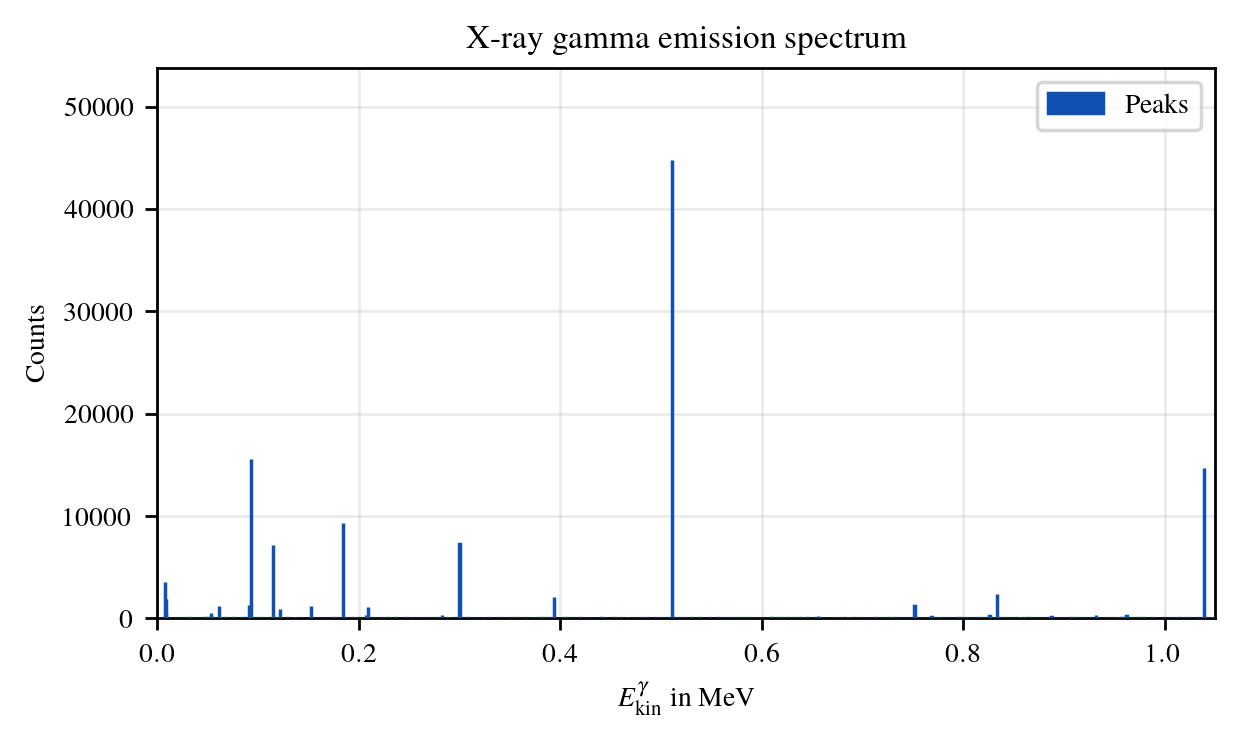

In [144]:
array_to_histo(data['Ekin'], mask_min=0, mask_max=1.05)
# array_to_histo(data['Ekin'], mask_max=520)

In [ ]:
xy.xray_transition_energy_eV(29, 'Ka2')


AttributeError: module 'pyne' has no attribute 'data'